In [1]:
import numpy as np
import math as mt


def monomFun(X, n):
    getVal = np.vectorize(lambda x: mt.pow(x, n))
    return getVal(X)


def getMonomSLAY(X, N):
    arr = np.zeros([N + 1, X.shape[0]])
    for i in range(arr.shape[0]):
        arr[i] = monomFun(X, i)
    return np.transpose(arr)


def vectorU(X):
    eVector = np.zeros([1, X.shape[0]])
    eVector[0][0] = 1
    if (np.sign(X[0]) == 1):
        tildaU = np.add(X, np.linalg.norm(X) * eVector)
    else:
        tildaU = np.subtract(X, np.linalg.norm(X) * eVector)

    uVector = np.divide(tildaU, np.linalg.norm(tildaU))
    return np.transpose(uVector)


def transformHouseholder(arrSLAY, arrY):
    ans = np.copy(arrSLAY)
    arrB = np.copy(arrY)
    n = ans.shape[0]
    for j in range(ans.shape[1]):
        U = vectorU(ans[j: n, j])

        ans[j:n, j:n] = np.subtract(ans[j:n, j:n],
                                    2 * np.dot(U,
                                               np.dot(np.transpose(U), ans[j:n, j:n])))

        arrB[j:n] = np.subtract(arrB[j:n],
                                2 * np.dot(U,
                                           np.dot(np.transpose(U), arrB[j:n])))

    checkZero = np.vectorize(lambda x: 0.0 if (abs(x) < 1e-15) else x)
    return checkZero(ans), checkZero(arrB)


def gaussReverse(arrSLAY, arrY):
    arrX = np.zeros([arrSLAY.shape[1]])
    n = arrSLAY.shape[0]
    j = arrSLAY.shape[1]
    if (abs(arrSLAY[j - 1, j - 1]) > 1e-15):
        arrX[j - 1] = arrY[j - 1] / arrSLAY[j - 1, j - 1]
    else:
        arrX[j - 1] = 0.0
    for i in range(1, j):
        multVector = np.multiply(arrSLAY[j - i - 1, j - i:j], arrX[j - i:j + 1])
        divideEl = arrSLAY[j - i - 1, j - i - 1]

        if (abs(divideEl) > 1e-15):
            arrX[j - 1 - i] = (arrY[j - i - 1] - np.sum(multVector)) / divideEl
        else:
            arrX[j - 1] = 0.0

    return np.reshape(arrX, [arrX.shape[0], 1])


def getXYVector(x0, xl, N, K):
    length = abs(xl - x0)
    h = length / (2 * K)

    yVector = np.zeros(shape=(N + 1))
    xVector = np.zeros(shape=((N + 2) * K))

    x = length / (K * (N + 2))
    xc = 2 * h
    xi = x

    for i in range(xVector.shape[0]):
        if (i < yVector.shape[0]):
            yVector[i] = (xi - xc) / h + 1

        xVector[i] = xi
        xi += x

    return xVector, yVector


def getCollocationEdu(yVector, N, K):
    lColMatrix = np.zeros(shape=[(N + 1), (N + 1)])

    for i in range(4, lColMatrix.shape[0]):
        lColMatrix[i] = mt.factorial(i) / (mt.factorial(i - 4))

    lColMatrix = np.transpose(lColMatrix)

    for i in range(5, lColMatrix.shape[0]):
        lColMatrix[:, i] = np.multiply(lColMatrix[:, i], np.power(yVector, i - 4))

    return lColMatrix


def borderCond(pb0, pb1, h, N, x):
    arrCond = np.zeros(shape=[2, (N + 1)])
    for i in range(arrCond.shape[1]):
        arrCond[0][i] = pb0 * mt.pow(x, i)
        arrCond[1][i] = pb1 * i * mt.pow(x, i - 1) / h
    return arrCond


def getNeighbor01(pm0, pm1, h, N, x, flag):
    arr = np.zeros(shape=(N + 1))

    if (flag == True):
        arr[0] = pm0 * x
        for i in range(1, arr.shape[0]):
            arr[i] = (pm0 * mt.pow(x, i) + (pm1 * i * mt.pow(x, i - 1)) / h)
            if (np.sign(x) != 1):
                arr[i] = - arr[i]
    else:
        arr[0] = -pm0 * x
        for i in range(1, arr.shape[0]):
            arr[i] = (pm0 * mt.pow(x, i) - (pm1 * i * mt.pow(x, i - 1)) / h)
            if (np.sign(x) == 1):
                arr[i] = - arr[i]

    return arr


def getNeighbor23(pm2, pm3, h, N, x, flag):
    arr = np.zeros(shape=(N + 1))
    arr2 = np.zeros(shape=(N + 1))
    arr3 = np.zeros(shape=(N + 1))

    for i in range(2, arr2.shape[0]):
        arr2[i] = mt.factorial(i) / (mt.factorial(i - 2))

    for i in range(3, arr2.shape[0]):
        arr3[i] = mt.factorial(i) / (mt.factorial(i - 3))

    if (flag == True):
        for i in range(2, arr.shape[0]):
            arr[i] = pm2 * arr2[i] * mt.pow(x, i - 2) / mt.pow(h, 2) + pm3 * arr3[i] * mt.pow(x, i - 3) / mt.pow(h, 3)
            if (np.sign(x) != 1):
                arr[i] = - arr[i]
    else:
        for i in range(2, arr.shape[0]):
            arr[i] = pm2 * arr2[i] * mt.pow(x, i - 2) / mt.pow(h, 2) - pm3 * arr3[i] * mt.pow(x, i - 3) / mt.pow(h, 3)
            if (np.sign(x) == 1):
                arr[i] = - arr[i]

    return arr


def rightAgreementCond(pm0, pm1, pm2, pm3, h, N):
    rightNeighbor1 = getNeighbor01(pm0, pm1, h, N, 1, True)

    rightNeighbor2 = getNeighbor01(pm0, pm1, h, N, -1, True)

    rightNeighbor3 = getNeighbor23(pm2, pm3, h, N, 1, True)

    rightNeighbor4 = getNeighbor23(pm2, pm3, h, N, -1, True)

    right = np.zeros(shape=[2, 2 * (N + 1)])
    right[0, 0: N + 1] = rightNeighbor1
    right[0, N + 1: 2 * (N + 1)] = rightNeighbor2
    right[1, 0: N + 1] = rightNeighbor3
    right[1, N + 1: 2 * (N + 1)] = rightNeighbor4

    return right


def leftAgreementCond(pm0, pm1, pm2, pm3, h, N):
    leftNeighbor1 = getNeighbor01(pm0, pm1, h, N, 1, False)

    leftNeighbor2 = getNeighbor01(pm0, pm1, h, N, -1, False)

    leftNeighbor3 = getNeighbor23(pm2, pm3, h, N, 1, False)

    leftNeighbor4 = getNeighbor23(pm2, pm3, h, N, -1, False)

    left = np.zeros(shape=[2, 2 * (N + 1)])
    left[0, 0: N + 1] = leftNeighbor1
    left[0, N + 1: 2 * (N + 1)] = leftNeighbor2
    left[1, 0: N + 1] = leftNeighbor3
    left[1, N + 1: 2 * (N + 1)] = leftNeighbor4

    return left


def testFun1(X):
    a1 = np.power(X + 7, 2)
    a2 = np.multiply(X, a1)
    a3 = a2 + 32
    a4 = np.multiply(X, a3)
    a5 = a4 - 12
    a6 = np.multiply(np.exp(X), a5)
    return a6


def testFun2(X):
    a1 = np.power(X, 2)
    a2 = np.power(X - 1, 2)
    a3 = np.multiply(a1, a2)
    a4 = np.multiply(np.exp(X), a3)
    return a4


def collocationMethod(x0, xl, N, K):
    length = abs(xl - x0)
    h = length / (2 * K)

    xVector, yVector = getXYVector(x0, xl, N, K)

    lColMatrix = getCollocationEdu(yVector, N, K)

    globMatrix = np.zeros(shape=[K * (N + 5), K * (N + 1)])
    bVector = np.zeros(shape=[K * (N + 5)])

    row = 0
    col = 0
    colx = 0

    pm0 = 1
    pm1 = h
    pm2 = h ** 2
    pm3 = h ** 3
    pb0 = 1
    pb1 = h

    koeff = 0
    g10 = pb0 * testFun1(x0) * koeff
    g20 = pb0 * testFun1(xl) * koeff
    g1l = pb1 * testFun1(x0) * koeff
    g2l = pb1 * testFun1(xl) * koeff

    left = leftAgreementCond(pm0, pm1, pm2, pm3, h, N)
    right = rightAgreementCond(pm0, pm1, pm2, pm3, h, N)

    for i in range(K):
        globMatrix[row: row + (N + 1), col: col + (N + 1)] = lColMatrix
        bVector[row: row + (N + 1)] = testFun1(xVector[colx: colx + (N + 1)]) * (mt.pow(h, 4))

        if (i == 0):
            # right and left border
            arrCond = borderCond(pb0, pb1, h, N, -1)
            globMatrix[N + 1: N + 1 + 2, 0: 2 * (N + 1)] = right
            globMatrix[N + 1 + 2: N + 1 + 4, 0: (N + 1)] = arrCond

            bVector[row + (N + 1) + 2:row + (N + 1) + 4] = [g10, g1l]

        elif (i == K - 1):
            # left and right border
            arrCond = borderCond(pb0, pb1, h, N, 1)
            row += (N + 1)
            col -= (N + 1)

            globMatrix[row: row + 2, col:col + 2 * (N + 1)] = left
            col += (N + 1)
            globMatrix[row + 2: row + 4, col:col + (N + 1)] = arrCond

            bVector[row + 2:row + 4] = [g20, g2l]

        else:
            # right and left

            # left
            rowAg = row + (N + 1)
            colAg = col - (N + 1)
            globMatrix[rowAg: rowAg + 2, colAg:colAg + 2 * (N + 1)] = left

            # rigth
            rowAg += 2
            colAg += (N + 1)
            globMatrix[rowAg: rowAg + 2, colAg:colAg + 2 * (N + 1)] = right

        row += (N + 1) + 4
        col += (N + 1)
        colx += (N + 2)

    return globMatrix, bVector


In [2]:
import matplotlib.pyplot as plt


def showData(a, b, X, Y, index, title=None, xlabel=None, ylabel=None,
             xticks=None, yticks=None, typePoint=None):
    splot = plt.subplot(a, b, index)
    plt.xlabel(xlabel, fontsize=14)
    plt.ylabel(ylabel, fontsize=14)
    plt.rcParams['font.size'] = '14'

    if (typePoint == None):
        plt.plot(X, Y)
    else:
        plt.plot(X, Y, marker=typePoint, label=title)
    plt.grid(True)
    plt.legend()

    if (xticks != None):
        plt.xticks(np.arange(min(X), max(X), xticks))
    if (yticks != None):
        plt.yticks(np.arange(min(Y), max(Y), yticks))

    return splot


def monomPoly(x, N):
    ans = np.zeros(shape=N + 1)
    for i in range(ans.shape[0]):
        ans[i] = mt.pow(x, i)

    return ans


def getValueCollocFun(xArr, coeffArr, N, K, x0, xl):
    length = abs(xl - x0)
    h = length / (2 * K)
    xc = 2 * h
    coeff = np.zeros(shape=(coeffArr.shape[0] + N + 1))
    coeff[0: K * (N + 1)] = np.transpose(coeffArr)[0]
    coeff[K * (N + 1): K * 2 * (N + 1)] = coeff[(K - 1) * (N + 1): K * (N + 1)]

    step = length / K
    stepArr = np.zeros(shape=K + 1)
    stepArr[0] = step
    for i in range(1, stepArr.shape[0] - 1):
        stepArr[i] += stepArr[i - 1] + step
    stepArr[K] = xl

    yVector = np.zeros(shape=xArr.shape)

    for i in range(xArr.shape[0]):
        j = 0
        col = 0
        x = xArr[i]
        while (x > step):
            x -= step
            j += 1
            col += N + 1

        yVal = (x - xc) / h + 1

        monomArr = monomPoly(yVal, N)
        monomWithKoeff = np.multiply(monomArr, coeff[col: col + N + 1])
        yVector[i] = np.sum(monomWithKoeff)

    return yVector


def infNorma(Yans, Yorig):
    absmax = np.max(np.abs(Yans - Yorig))
    infmax = absmax / np.max(Yorig)
    return infmax, absmax

In [3]:
import time
import pandas as pd


def main():
    x0 = 0
    xl = 1
    N = 4
    kList = [5, 10, 20, 40, 80, 160]

    ansArr = np.zeros(shape=[6, 7])

    for i in range(len(kList)):

        print("start K = ", kList[i])

        start_time = time.time()
        globMatrix, bVector = collocationMethod(x0, xl, N, kList[i])
        globMatrix2, bVector2 = collocationMethod(x0, xl, N, int(kList[i] / 2))

        if (i == 0):
            ans = pd.DataFrame(globMatrix)

        ans, arrB = transformHouseholder(globMatrix, bVector)
        ans2, arrB2 = transformHouseholder(globMatrix2, bVector2)

        # gauss Reverse
        arrAnsX = gaussReverse(ans, arrB)
        arrAnsX2 = gaussReverse(ans2, arrB2)

        times = time.time() - start_time

        step = 1
        xMax = 1000
        xArr = np.array([i for i in range(0, xMax, step)]) / xMax

        yVector = getValueCollocFun(xArr, arrAnsX, N, kList[i], x0, xl)
        yVector2 = getValueCollocFun(xArr, arrAnsX2, N, int(kList[i] / 2), x0, xl)

        infN, absN = infNorma(yVector, testFun2(xArr))
        infN2, absN2 = infNorma(yVector2, testFun2(xArr))
        R1 = -np.log2(infN / infN2)
        R2 = -np.log2(absN / absN2)

        ansArr[i][0] = kList[i]
        ansArr[i][1] = infN
        if (i != 0):
            ansArr[i][2] = R1
        ansArr[i][3] = absN
        if (i != 0):
            ansArr[i][4] = R2
        ansArr[i][5] = np.linalg.cond(globMatrix)
        ansArr[i][6] = times

        plt.figure(figsize=(15, 25), facecolor='white')
        showData(len(kList), 1, xArr, testFun2(xArr), 1, "exact solution", "X", "Y", 0.05, 0.01, '^')
        showData(len(kList), 1, xArr, yVector, 1, "approximate solution for K = " + str(kList[i]),
                    "X", "Y", 0.05, 0.01, 'o')

        plt.show()

    return ansArr, ans

start K =  5


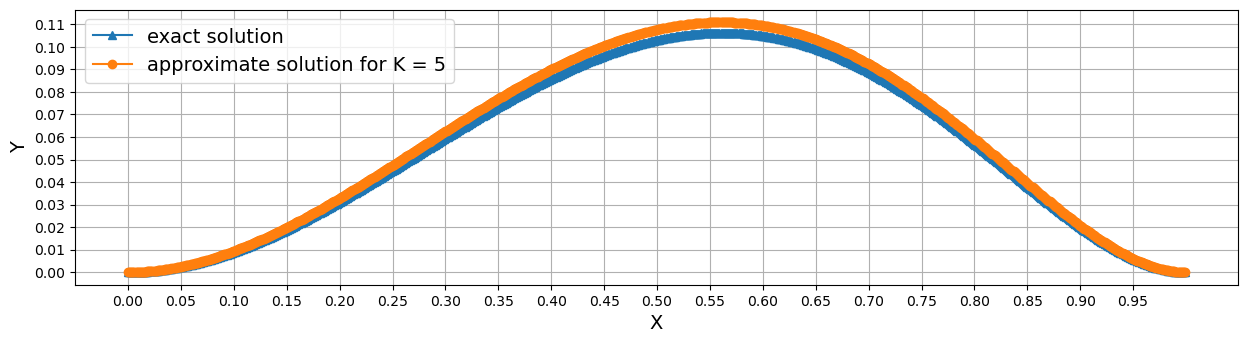

start K =  10


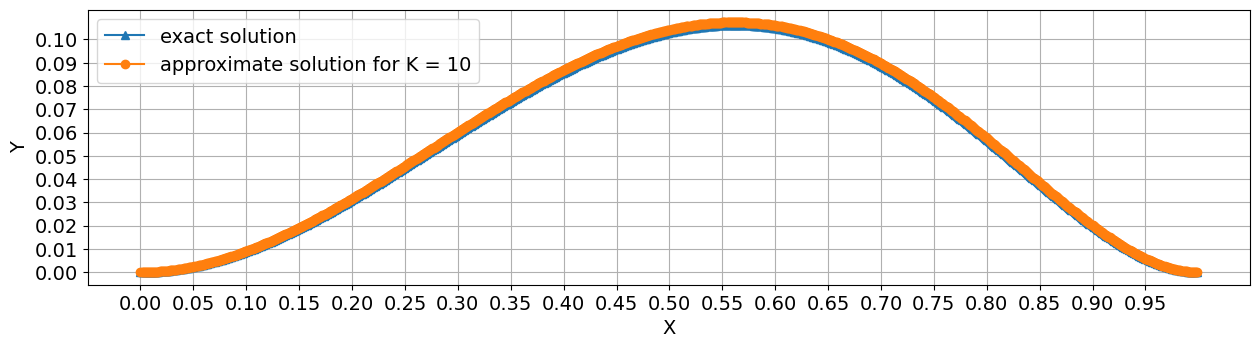

start K =  20


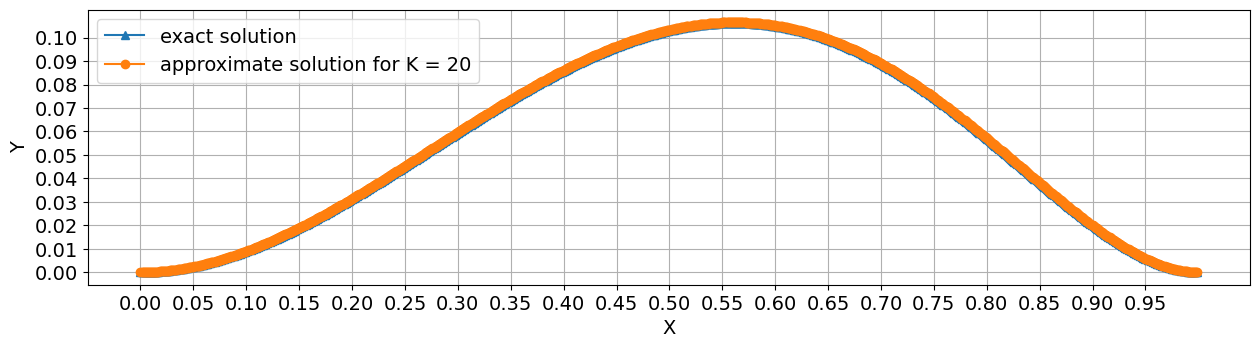

start K =  40


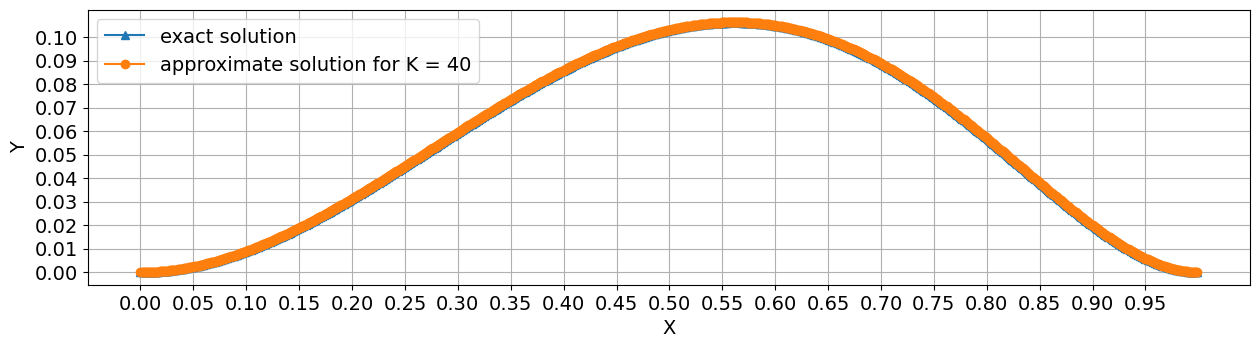

start K =  80


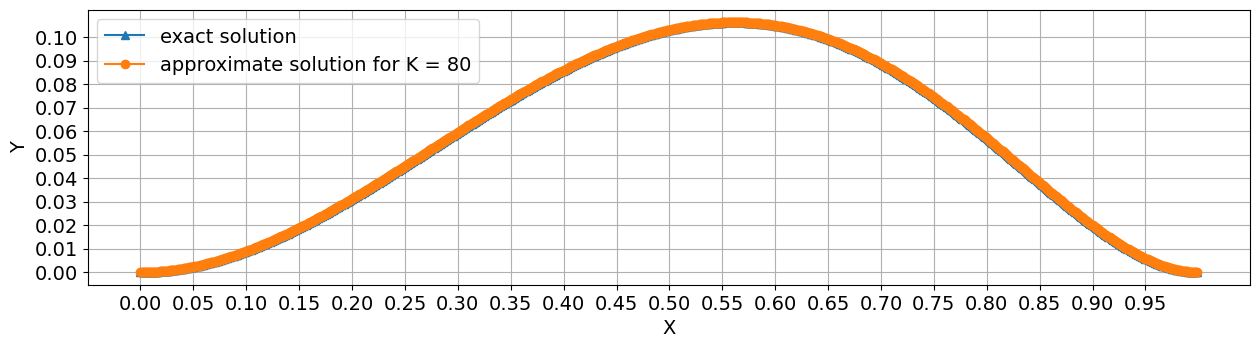

start K =  160


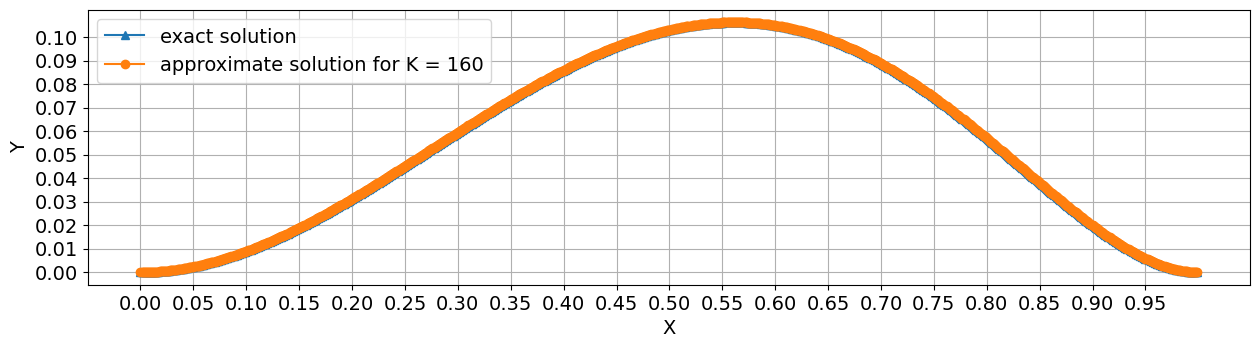

       K        Ea         R        Er         R       cond(A)      tsol
0    5.0  0.043987  0.000000  0.004675  0.000000  1.085440e+03  0.003568
1   10.0  0.010670  2.043525  0.001134  2.043525  1.612399e+04  0.014541
2   20.0  0.002642  2.013624  0.000281  2.013624  2.552527e+05  0.020884
3   40.0  0.000659  2.003319  0.000070  2.003319  4.074354e+06  0.097014
4   80.0  0.000165  2.000852  0.000018  2.000852  6.515163e+07  1.220499
5  160.0  0.000041  2.000209  0.000004  2.000209  1.042274e+09  4.602648


In [4]:
if __name__ == "__main__":
    arrTab, ans = main()
    arrPD = pd.DataFrame(arrTab, columns=["K", "Ea", "R", "Er", "R", "cond(A)", "tsol"])
    print(arrPD)